# Investigating competition effects between 8 theoretical pre-miRNAs

## Set up workspace

In [1]:
import model_utils as mu
import params
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from tqdm import tqdm

C:\Users\Sofia\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Sofia\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
destdir_csvs = './outputs/8sp-comp/csvs2/'
destdir_figs = './outputs/8sp-comp/plots2/'

## Generate model

In [3]:
#make 2 miRNA model
ODE_inits = [0]*8*4 + [0]
ODE_ka = [0] * 8
ODE_kb = ODE_ka
ODE_kc = ODE_ka
ODE_kd = ODE_ka

In [4]:
ode = mu.makeODEs(ODE_inits, ODE_ka, ODE_kb, ODE_kc, ODE_kd)

In [5]:
model = mu.makeModel(ode)

In [6]:
#control model
ode_control = mu.makeODEs([0]*5, [0], [0], [0], [0])
model_control = mu.makeModel(ode_control)

## Set up conditions for models

In [7]:
high = 10
low = 1
k = 2

In [8]:
inits1 = [params.init_pMiR1, params.init_pMiR1_dcr, params.init_pMiR1_dcr_star, params.init_MiR1] * 8

In [9]:
ka = [params.ka1 * high, params.ka1 * low] + [params.ka1] * 2 +\
     [params.ka1 * high * k, params.ka1 * low] + [params.ka1 * k] * 2

kb = [params.ka1 * params.Kd_wt, params.ka1 * params.Kd_wt * high]  + \
    [params.ka1 * params.Kd_wt] * 2 + \
    [params.ka1 * params.Kd_wt, params.ka1 * params.Kd_wt * high * k] +\
    [params.ka1 * params.Kd_wt] * 2

kc = [params.kc1] * 2 + [params.kc1 * high, params.kc1] + \
     [params.kc1] * 2 + [params.kc1 * high * k, params.kc1]

kd = [params.kd1] * 3 + [params.kd1 * high] + [params.kd1] * 3 + [params.kd1 * high * k]

In [10]:
dvars = np.linspace(0, 7.25, 15)
dvars[0] = 0.01
dvars = np.append(dvars, np.linspace(10, 15, 4))
variations = [str(int(i * 100)) for i in list(dvars)]

In [65]:
#conditions for control model
inits_control = [params.init_pMiR1, params.init_pMiR1_dcr, params.init_pMiR1_dcr_star, 
                 params.init_MiR1]

## Run model, save outputs

In [12]:
exec(model)

In [13]:
names = []
for i in tqdm(range(len(dvars))):
    init = inits1 + [dvars[i]]
     #up time model run to reach steady state
    res = solve_ivp(runModel, (0, 3000), init, \
                    args = (ka, kb, kc, kd), method = 'LSODA')
    
    mirna_length = int((len(res.y)-1)/4)
    index = []
    
    for j in range(mirna_length):
        index = index + ['pMiR' + str(j), 'pMiR_dicer' + str(j), \
                         'pMiR_dicer_star' + str(j), 'miR' + str(j)]
    
    index = index + ['dicer']
    
    df = pd.DataFrame(res.y, index = index)
    df = df.transpose()
    df.insert(loc = 0, column = 'time_min', value = res.t)
    
    name = 'model_' + variations[i]
    names.append(name)
    
    df.to_csv(destdir_csvs + name + '.csv', index = False)

100%|██████████| 19/19 [00:00<00:00, 38.35it/s]


In [14]:
#run control model
exec(model_control)

In [15]:
names_control = []
for l in tqdm(range(len(ka))):
    for i in range(len(dvars)):
        init = inits_control + [dvars[i]]
        #up time model run to reach steady state
        res = solve_ivp(runModel, (0, 3000), init, \
                        args = ([ka[l]], [kb[l]], [kc[l]], [kd[l]]), method = 'LSODA')
        mirna_length = int((len(res.y)-1)/4)
        index = []
    
        index = ['pMiR', 'pMiR_dicer', 'pMiR_dicer_star', 'miR', 'dicer']
        
        df = pd.DataFrame(res.y, index = index)
        df = df.transpose()
        df.insert(loc = 0, column = 'time_min', value = res.t)
    
        name = 'miRNA' + str(l) + '_control_' + variations[i]
        names_control.append(name)
    
        df.to_csv(destdir_csvs + name + '.csv', index = False)

100%|██████████| 8/8 [00:00<00:00, 11.81it/s]


## Plot models

### Load data

In [16]:
#Only run if needing to load old data
names_control = []
names = []

for i in range(len(dvars)):
    
    name = 'model_' + variations[i]
    names.append(name)
    
    for l in range(len(ka)):
        name2 = 'miRNA' + str(l) + '_control_' + variations[i]
        names_control.append(name2)

In [17]:
for name in names:
    exec(name  + ' = pd.read_csv("' + destdir_csvs + name + '.csv", header = [0])')

In [18]:
for name in names_control:
    exec(name  + ' = pd.read_csv("' + destdir_csvs + name + '.csv", header = [0])')

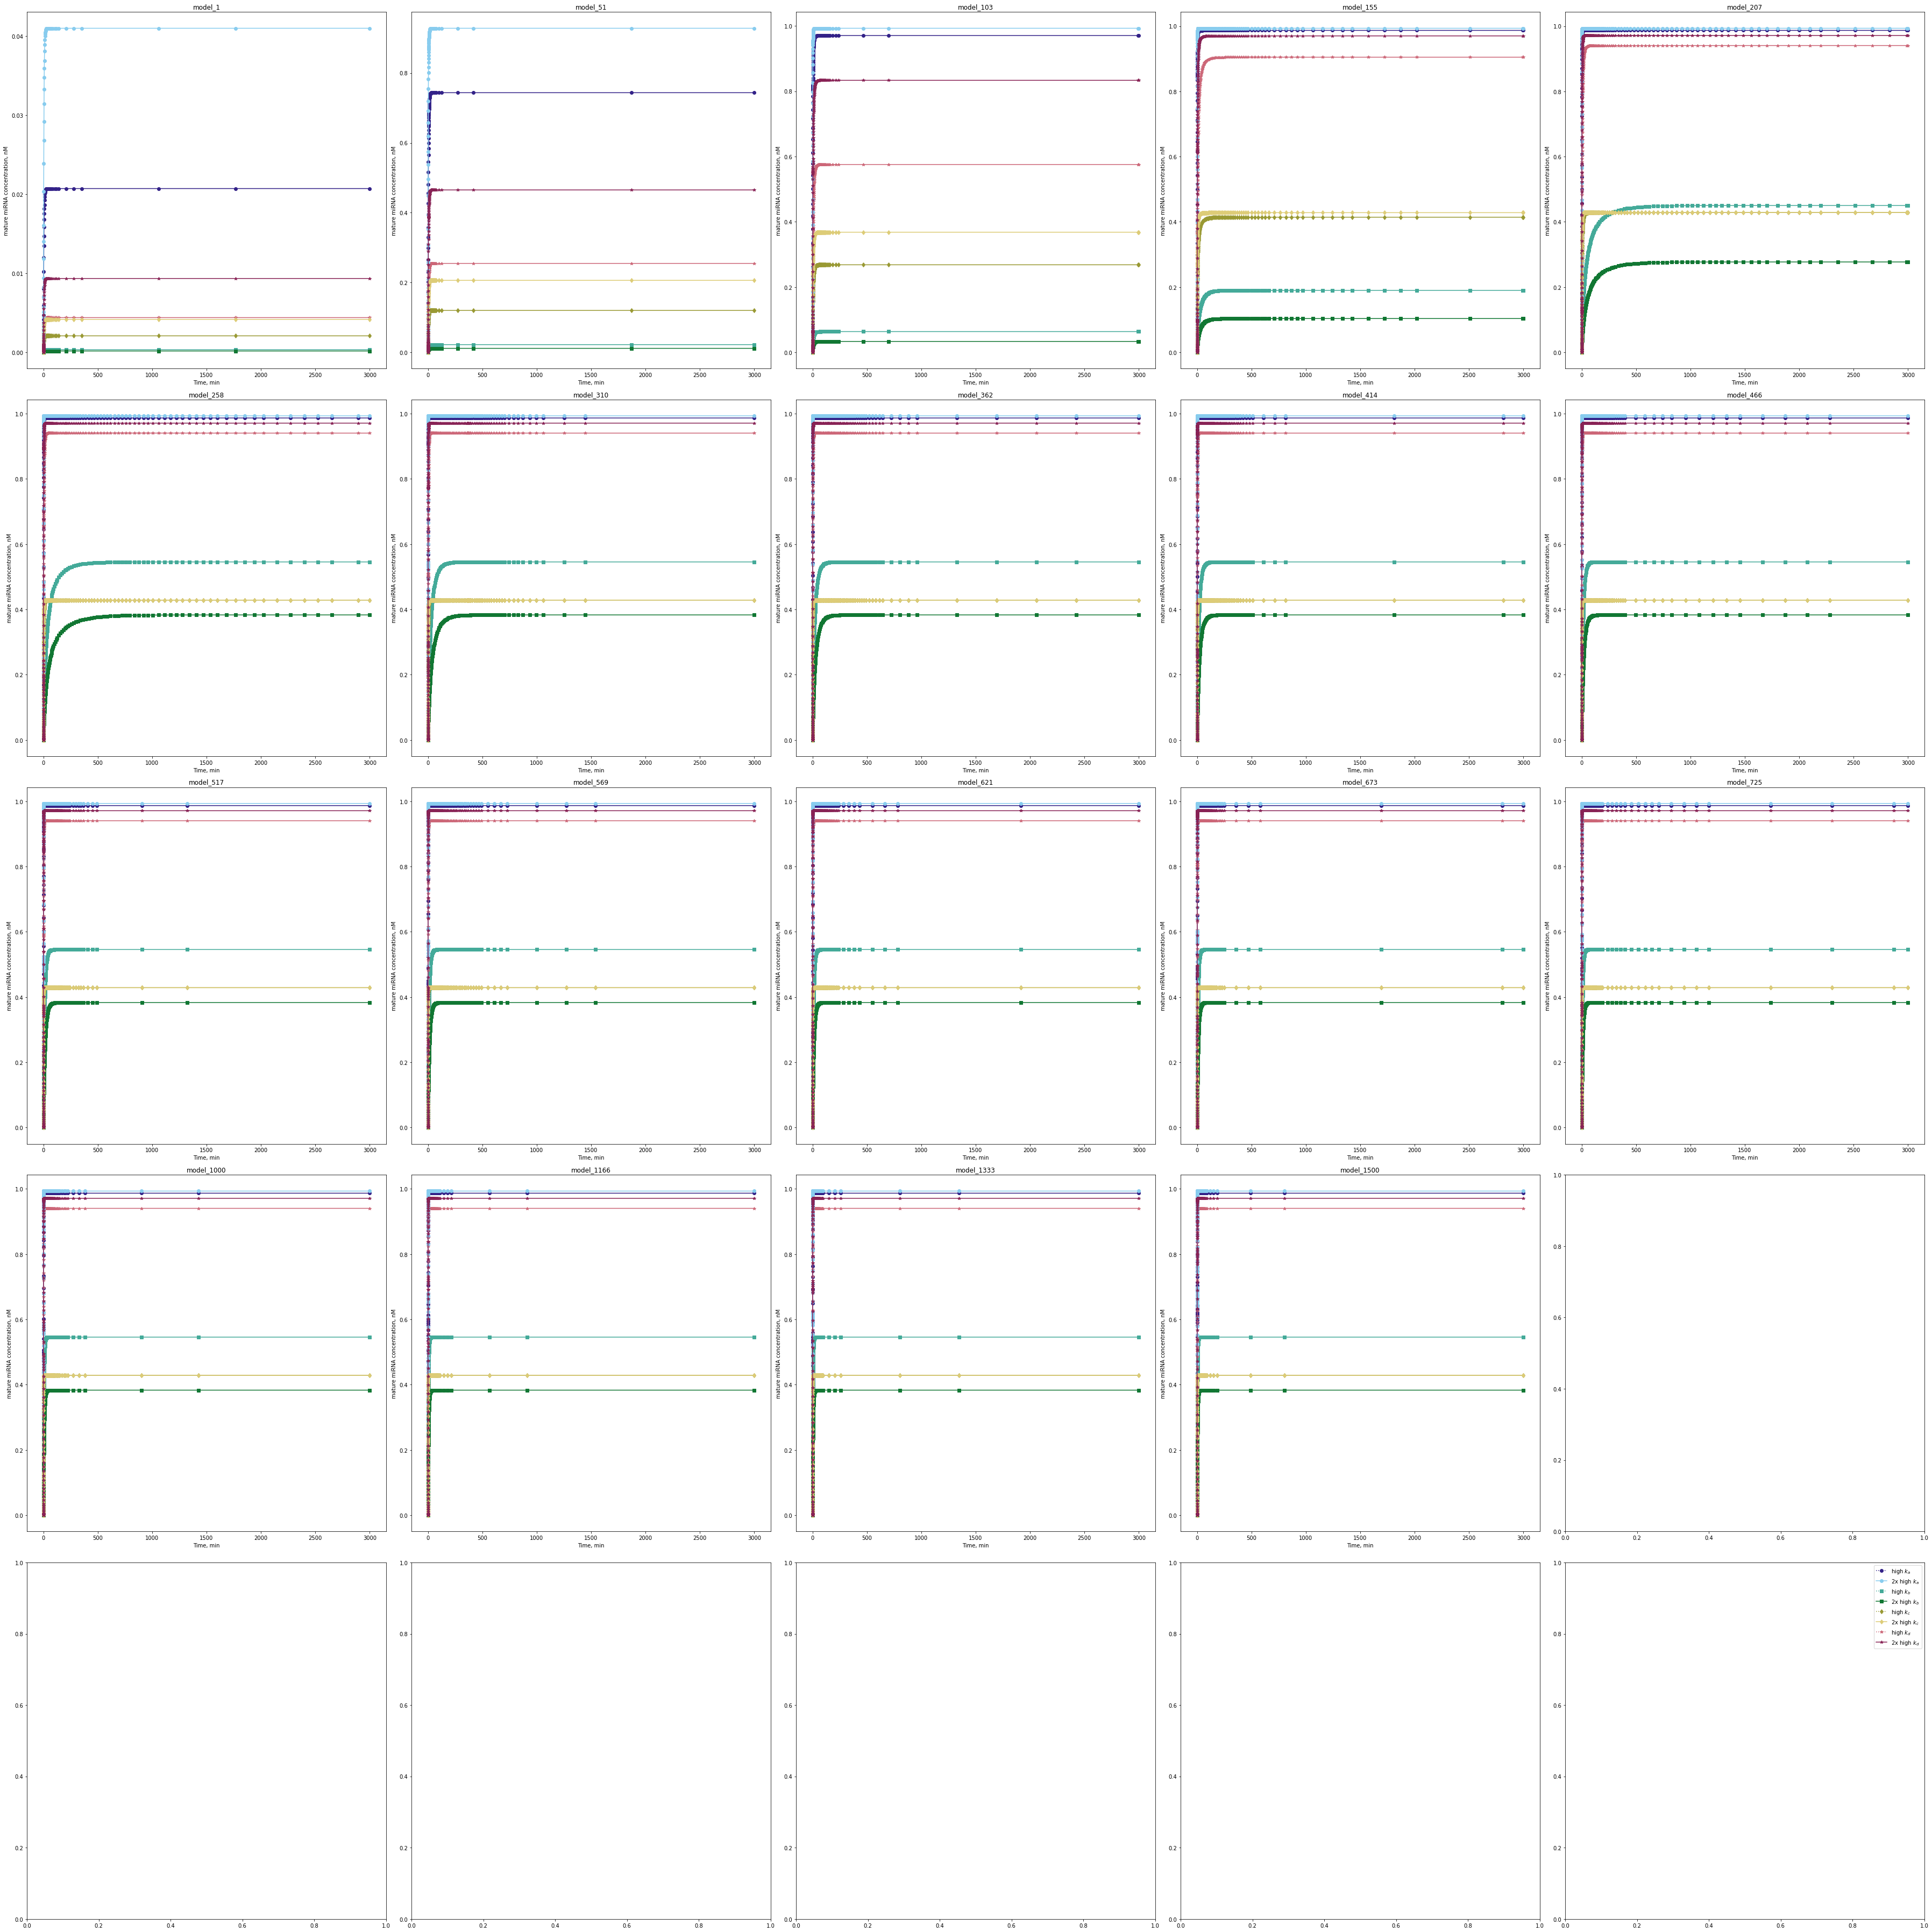

In [19]:
#Check if steady state reached
import math

def createCoordinates(xx, yy):
    coords = []
    for i in range(xx):
        for j in range(yy):
            coords.append((i, j))
    return coords

plot_grid = math.ceil(math.sqrt(len(names)))
coords = createCoordinates(plot_grid, plot_grid)

legs = ['high $k_a$', 'high $k_b$', 'high $k_c$', 'high $k_d$']
legs += [str(int(k)) + 'x ' + i for i in legs]

fig, ax = plt.subplots(plot_grid, plot_grid, figsize = (50,50))

for i in range(len(names)):
    exec('mir = ' + names[i])
    ax[coords[i]].plot(mir['time_min'],
                       mir['miR0'],
                       color = params.colors[0][0],
                       marker = 'o')
    ax[coords[i]].plot(mir['time_min'],
                       mir['miR1'],
                       color = params.colors[1][0],
                       marker = 's')
    ax[coords[i]].plot(mir['time_min'],
                       mir['miR2'],
                       color = params.colors[2][0],
                       marker = 'd')
    ax[coords[i]].plot(mir['time_min'],
                       mir['miR3'],
                       color = params.colors[3][0],
                       marker = '*')
    
    ax[coords[i]].plot(mir['time_min'],
                       mir['miR4'],
                       color = params.colors[0][1],
                       marker = 'o')
    ax[coords[i]].plot(mir['time_min'],
                       mir['miR5'],
                       color = params.colors[1][1],
                       marker = 's')
    ax[coords[i]].plot(mir['time_min'],
                       mir['miR6'],
                       color = params.colors[2][1],
                       marker = 'd')
    ax[coords[i]].plot(mir['time_min'],
                       mir['miR7'],
                       color = params.colors[3][1],
                       marker = '*')
    ax[coords[i]].set_ylabel('mature miRNA concentration, nM')
    ax[coords[i]].set_title(names[i])
    ax[coords[i]].set_xlabel('Time, min')

leg1 = []
leg2 = []
markers = ['o', 's', 'd', '*']
for i in range(len(legs)):
    if i < 4:
        leg1.append(mlines.Line2D([], [], linestyle = ':', marker = markers[i], \
                                 color = params.colors[i][0], label = legs[i]))
    else:
        leg2.append(mlines.Line2D([], [], linestyle = '-', marker = markers[i-4], \
                                 color = params.colors[i-4][1], label = legs[i]))
leg = []
for i in range(len(leg1)):
    leg.append(leg1[i])
    leg.append(leg2[i])
plt.legend(handles = leg)

fig.tight_layout()

plt.show()

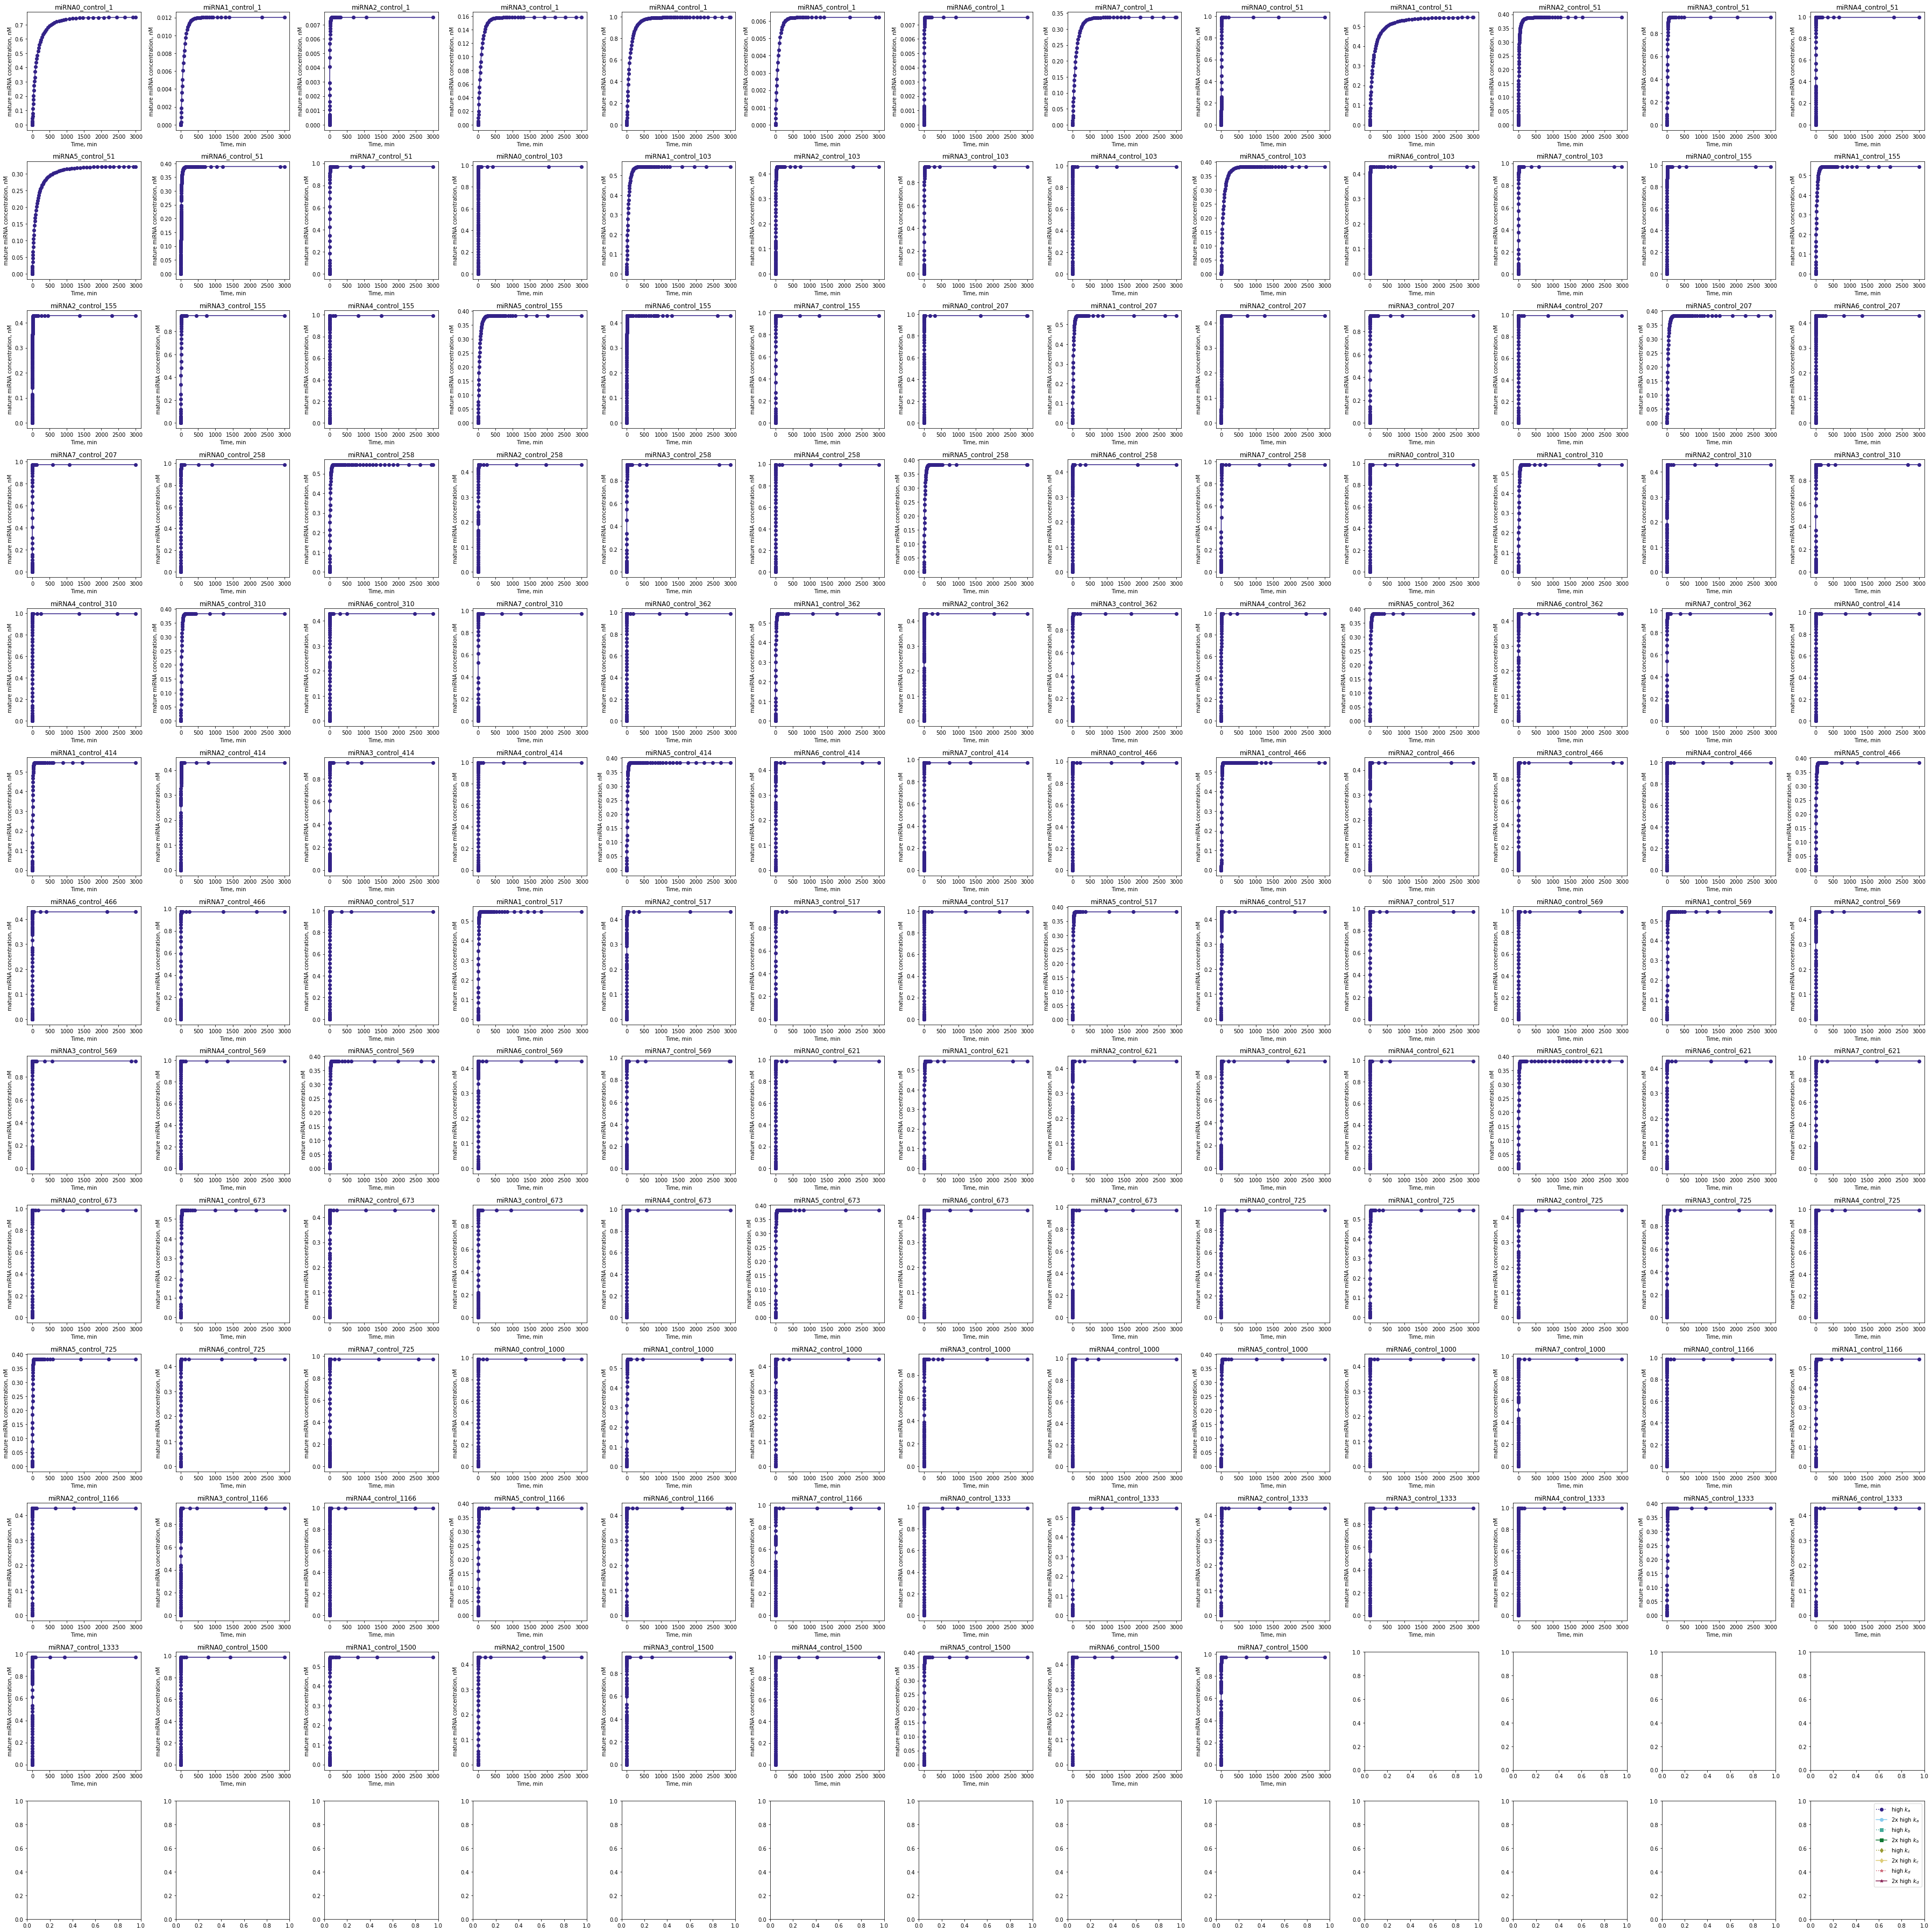

In [20]:
#Check if steady state reached
import math

def createCoordinates(xx, yy):
    coords = []
    for i in range(xx):
        for j in range(yy):
            coords.append((i, j))
    return coords

plot_grid = math.ceil(math.sqrt(len(names_control)))
coords = createCoordinates(plot_grid, plot_grid)

legs = ['high $k_a$', 'high $k_b$', 'high $k_c$', 'high $k_d$']
legs += [str(int(k)) + 'x ' + i for i in legs]

fig, ax = plt.subplots(plot_grid, plot_grid, figsize = (50,50))

for i in range(len(names_control)):
    exec('mir = ' + names_control[i])
    ax[coords[i]].plot(mir['time_min'],
                       mir['miR'],
                       color = params.colors[0][0],
                       marker = 'o')
    ax[coords[i]].set_ylabel('mature miRNA concentration, nM')
    ax[coords[i]].set_title(names_control[i])
    ax[coords[i]].set_xlabel('Time, min')

leg1 = []
leg2 = []
markers = ['o', 's', 'd', '*']
for i in range(len(legs)):
    if i < 4:
        leg1.append(mlines.Line2D([], [], linestyle = ':', marker = markers[i], \
                                 color = params.colors[i][0], label = legs[i]))
    else:
        leg2.append(mlines.Line2D([], [], linestyle = '-', marker = markers[i-4], \
                                 color = params.colors[i-4][1], label = legs[i]))
leg = []
for i in range(len(leg1)):
    leg.append(leg1[i])
    leg.append(leg2[i])
plt.legend(handles = leg)

fig.tight_layout()

plt.show()

In [21]:
#mirna species names
mirnas = ['high $k_a$', 'high $k_b$', 'high $k_c$', 'high $k_d$']
mirnas += [str(int(k)) + 'x ' + i for i in mirnas]

In [22]:
#prep endpoints for plotting
ends = {'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': []}
fc = {'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': []}

for i in range(len(names)):
    exec('miR = ' + names[i])
    exec('mod_max = ' + names[-1])
    
    ends['0'].append(miR['miR0'].iloc[-1])
    ends['1'].append(miR['miR1'].iloc[-1])
    ends['2'].append(miR['miR2'].iloc[-1])
    ends['3'].append(miR['miR3'].iloc[-1])
    ends['4'].append(miR['miR4'].iloc[-1])
    ends['5'].append(miR['miR5'].iloc[-1])
    ends['6'].append(miR['miR6'].iloc[-1])
    ends['7'].append(miR['miR7'].iloc[-1])
    
    fc['0'].append(miR['miR0'].iloc[-1] / mod_max['miR0'].iloc[-1])
    fc['1'].append(miR['miR1'].iloc[-1] / mod_max['miR1'].iloc[-1])
    fc['2'].append(miR['miR2'].iloc[-1] / mod_max['miR2'].iloc[-1])
    fc['3'].append(miR['miR3'].iloc[-1] / mod_max['miR3'].iloc[-1])
    fc['4'].append(miR['miR4'].iloc[-1] / mod_max['miR4'].iloc[-1])
    fc['5'].append(miR['miR5'].iloc[-1] / mod_max['miR5'].iloc[-1])
    fc['6'].append(miR['miR6'].iloc[-1] / mod_max['miR6'].iloc[-1])
    fc['7'].append(miR['miR7'].iloc[-1] / mod_max['miR7'].iloc[-1])

In [23]:
#prep endpoints for control cases
ends_control = {}
fc_control = {}

for i in range(len(ka)):
    ends_control[str(i)] = []
    fc_control[str(i)] = []
    for var in variations:
        exec('miR = miRNA' + str(i) + '_control_' + var)
        exec('mod_max = miRNA' + str(i) + '_control_' + variations[-1])
        
        ends_control[str(i)].append(miR['miR'].iloc[-1])
        fc_control[str(i)].append(miR['miR'].iloc[-1] / mod_max['miR'].iloc[-1])

In [24]:
#markerstyles
markers = ['o', 's', 'd', '*']

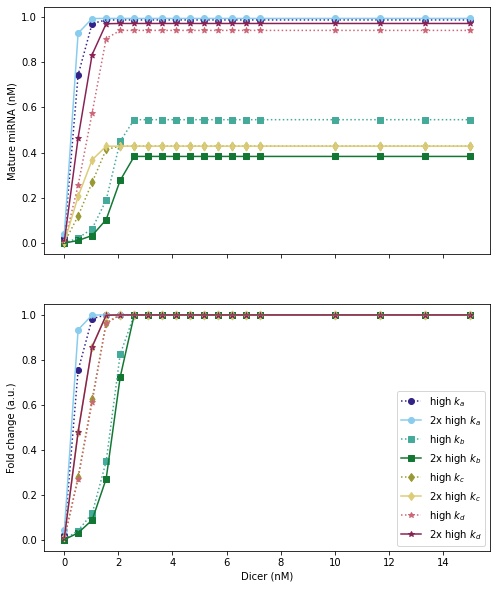

In [25]:
fig, ax = plt.subplots(2, sharex = True, figsize = (8, 10))

ax[0].set_ylabel('Mature miRNA (nM)')
ax[1].set_ylabel('Fold change (a.u.)')
ax[1].set_xlabel('Dicer (nM)')

for i in range(8):
    if i < 4:
        ax[0].plot(dvars,
                   ends[str(i)],
                   color = params.colors[i][0],
                   linestyle = ':')
        ax[1].plot(dvars,
                   fc[str(i)],
                   color = params.colors[i][0],
                   linestyle = ':')
        
        ax[0].scatter(dvars,
                      ends[str(i)],
                      color = params.colors[i][0],
                      marker = markers[i],
                     linewidths = 1,)
        ax[1].scatter(dvars,
                      fc[str(i)],
                      color = params.colors[i][0],
                      marker = markers[i],
                     linewidths = 1,)
        
    else:
        ax[0].plot(dvars,
                   ends[str(i)],
                   color = params.colors[i-4][1],
                   linestyle = '-')
        ax[1].plot(dvars,
                   fc[str(i)],
                   color = params.colors[i-4][1],
                   linestyle = '-')
        
        ax[0].scatter(dvars,
                      ends[str(i)],
                      color = params.colors[i-4][1],
                      marker = markers[i-4],
                     linewidths = 1,)
        ax[1].scatter(dvars,
                      fc[str(i)],
                      color = params.colors[i-4][1],
                      marker = markers[i-4],
                     linewidths = 1,)
        
leg1 = []
leg2 = []
for i in range(len(mirnas)):
    if i < 4:
        leg1.append(mlines.Line2D([], [], linestyle = ':', marker = markers[i], \
                                 color = params.colors[i][0], label = mirnas[i]))
    else:
        leg2.append(mlines.Line2D([], [], linestyle = '-', marker = markers[i-4], \
                                 color = params.colors[i-4][1], label = mirnas[i]))
leg = []
for i in range(len(leg1)):
    leg.append(leg1[i])
    leg.append(leg2[i])
plt.legend(handles = leg)

plt.savefig(destdir_figs + 'mat_mirna-fc.svg', dpi = 600, bbox_inches = 'tight')
        
plt.show()

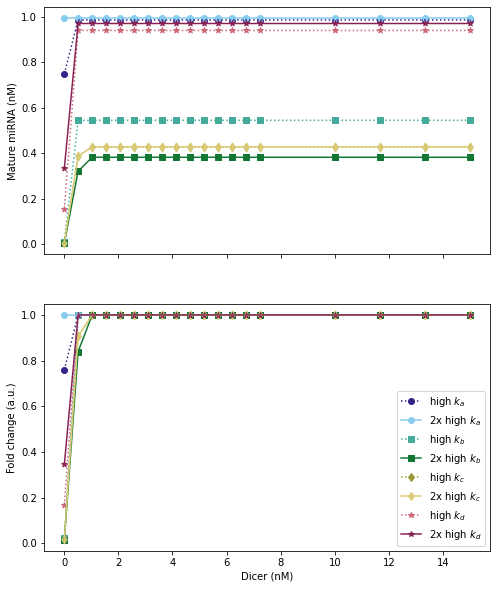

In [26]:
#plot control conditions
fig, ax = plt.subplots(2, sharex = True, figsize = (8, 10))

ax[0].set_ylabel('Mature miRNA (nM)')
ax[1].set_ylabel('Fold change (a.u.)')
ax[1].set_xlabel('Dicer (nM)')

for i in range(8):
    if i < 4:
        ax[0].plot(dvars,
                   ends_control[str(i)],
                   color = params.colors[i][0],
                   linestyle = ':')
        ax[1].plot(dvars,
                   fc_control[str(i)],
                   color = params.colors[i][0],
                   linestyle = ':')
        
        ax[0].scatter(dvars,
                      ends_control[str(i)],
                      color = params.colors[i][0],
                      marker = markers[i],
                     linewidths = 1,)
        ax[1].scatter(dvars,
                      fc_control[str(i)],
                      color = params.colors[i][0],
                      marker = markers[i],
                     linewidths = 1,)
        
    else:
        ax[0].plot(dvars,
                   ends_control[str(i)],
                   color = params.colors[i-4][1],
                   linestyle = '-')
        ax[1].plot(dvars,
                   fc_control[str(i)],
                   color = params.colors[i-4][1],
                   linestyle = '-')
        
        ax[0].scatter(dvars,
                      ends_control[str(i)],
                      color = params.colors[i-4][1],
                      marker = markers[i-4],
                     linewidths = 1)
        ax[1].scatter(dvars,
                      fc_control[str(i)],
                      color = params.colors[i-4][1],
                      marker = markers[i-4],
                     linewidths = 1,)
        
leg1 = []
leg2 = []
for i in range(len(mirnas)):
    if i < 4:
        leg1.append(mlines.Line2D([], [], linestyle = ':', marker = markers[i], \
                                 color = params.colors[i][0], label = mirnas[i]))
    else:
        leg2.append(mlines.Line2D([], [], linestyle = '-', marker = markers[i-4], \
                                 color = params.colors[i-4][1], label = mirnas[i]))
leg = []
for i in range(len(leg1)):
    leg.append(leg1[i])
    leg.append(leg2[i])
plt.legend(handles = leg)

plt.savefig(destdir_figs + 'mat_mirna-fc_controls.svg', dpi = 600, bbox_inches = 'tight')
        
plt.show()

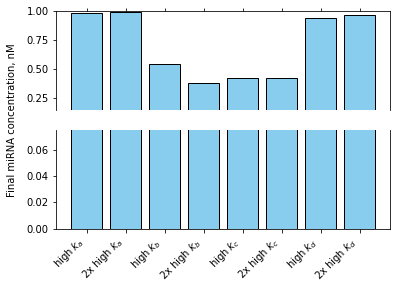

In [27]:
# plot bar chart of final miRNA %
x = np.linspace(1, 8, 8)
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True)
plt.xticks(rotation=45, ha='right')

ax = fig.add_subplot(111)
ax.set_ylabel('Final miRNA concentration, nM\n')
for spine in ax.spines:
    ax.spines[spine].set_color('none')
ax.tick_params(labelcolor='None', top=False, bottom=False, left=False, right=False)
ax.set(facecolor='None')

labels = []
    
for i in range(4):
    ax1.bar([x[int(i*2)], x[int(i*2)+1]],
            height = [ends[str(i)][-1], ends[str(i+4)][-1]],
            color = params.colors[0][1],
            edgecolor = 'black')
    ax2.bar([x[int(i*2)], x[int(i*2)+1]],
            height = [ends[str(i)][-1], ends[str(i+4)][-1]],
            color = params.colors[0][1],
            edgecolor = 'black')
    labels.append(mirnas[i])
    labels.append(mirnas[i+4])
    
ax1.set_xticks(x, labels)    
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax2.set_ylim(0,0.075)
ax1.set_ylim(0.15,1.)

plt.savefig(destdir_figs + 'max_expression.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

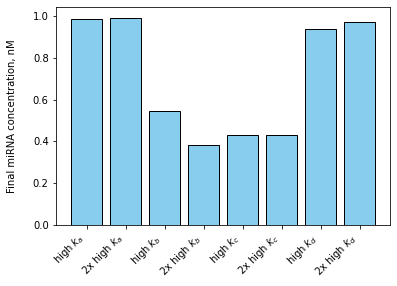

In [28]:
fig, ax = plt.subplots()
plt.xticks(rotation=45, ha='right')
labels = []
for i in range(4):
    ax.bar([x[int(i*2)], x[int(i*2)+1]],
            height = [ends[str(i)][-1], ends[str(i+4)][-1]],
            color = params.colors[0][1],
            edgecolor = 'black')
    
    labels.append(mirnas[i])
    labels.append(mirnas[i+4])
    
ax.set_ylabel('Final miRNA concentration, nM\n')
ax.set_xticks(x, labels)

plt.savefig(destdir_figs + 'max_expression2.svg', dpi = 600, bbox_inches = 'tight')

plt.show()


In [29]:
#find Dicer concentration required to reach .50 FC
_50 = {}
_50_control = {}
for key in fc:
    _50[key] = np.interp(.5, fc[key], dvars)
    _50_control[key] = np.interp(.5, fc_control[key], dvars)

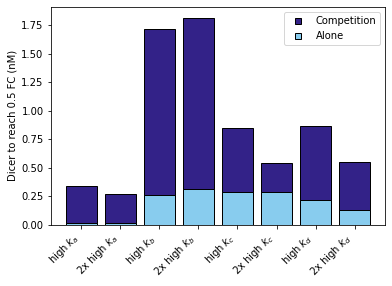

In [30]:
#plot bar chart with Dicer concentration 
fig, ax = plt.subplots()

plt.xticks(rotation = 45, ha = 'right')
labels = []
for i in range(4):
    ax.bar([x[int(i*2)], x[int(i*2)+1]],
           height = [_50[str(i)], _50[str(i+4)]],
           color = params.colors[0][0],
            edgecolor = 'black')
    ax.bar([x[int(i*2)], x[int(i*2)+1]],
           height = [_50_control[str(i)], _50_control[str(i+4)]],
           color = params.colors[0][1],
            edgecolor = 'black')
    
    labels.append(mirnas[i])
    labels.append(mirnas[i+4])

ax.set_xticks(x, labels)
ax.set_ylabel('Dicer to reach 0.5 FC (nM)')

l1 = mlines.Line2D([], [], linestyle = 'none', marker = 's', markersize = 6,\
                   color = params.colors[0][0], markeredgecolor = 'black', label = 'Competition')
l2 = mlines.Line2D([], [], linestyle = 'none', marker = 's', markersize = 6,\
                   color = params.colors[0][1], markeredgecolor = 'black', label = 'Alone')

plt.legend(handles = [l1, l2])
plt.savefig(destdir_figs + '50FC_Dicer.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [31]:
_50_control[str(i)]/_50[str(i)]

0.24568244207370188

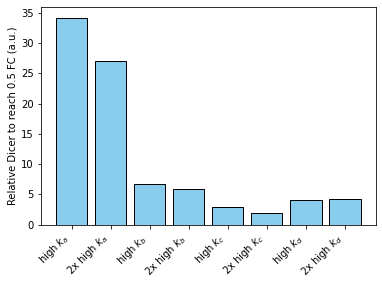

In [32]:
#plot bar chart with Dicer concentration 
fig, ax = plt.subplots()

plt.xticks(rotation = 45, ha = 'right')
labels = []
for i in range(4):
    ax.bar([x[int(i*2)], x[int(i*2)+1]],
           height = [_50[str(i)]/_50_control[str(i)], _50[str(i+4)]/_50_control[str(i+4)]],
           color = params.colors[0][1],
           edgecolor = 'black')
    labels.append(mirnas[i])
    labels.append(mirnas[i+4])

ax.set_xticks(x, labels)
ax.set_ylabel('Relative Dicer to reach 0.5 FC (a.u.)')


plt.savefig(destdir_figs + 'relative_50FC_Dicer.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

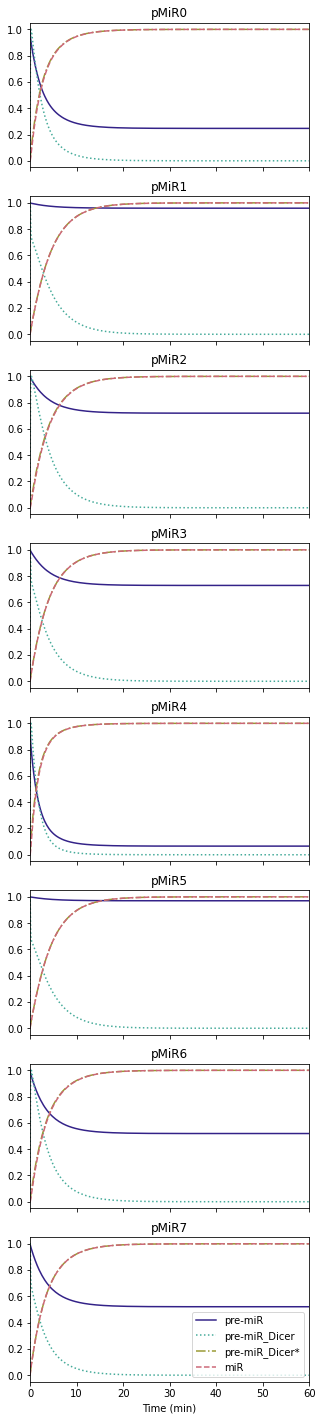

In [33]:
#plot all species on same plot for .5nM Dicer
fig, ax = plt.subplots(8, sharex = True, sharey = True, figsize = (5, 25))

for i in range(8):
    
    ax[i].plot(model_51['time_min'],
               model_51['pMiR' + str(i)] / np.max(np.array(model_51['pMiR' + str(i)])),
               color = params.colors[0][0],
               linestyle = ['-', ':', '-.', '--'][0])
    ax[i].plot(model_51['time_min'],
               model_51['pMiR_dicer' + str(i)] / np.max(np.array(model_51['pMiR_dicer' + str(i)])),
               color = params.colors[1][0],
               linestyle = ['-', ':', '-.', '--'][1])
    ax[i].plot(model_51['time_min'],
               model_51['pMiR_dicer_star' + str(i)] / np.max(np.array(model_51['pMiR_dicer_star' + str(i)])),
               color = params.colors[2][0],
               linestyle = ['-', ':', '-.', '--'][2])
    ax[i].plot(model_51['time_min'],
               model_51['miR' + str(i)] / np.max(np.array(model_51['miR' + str(i)])),
               color = params.colors[3][0],
               linestyle = ['-', ':', '-.', '--'][3])
    ax[i].set_title('pMiR' + str(i))
    ax[i].set_xlim(0, 60)
    
    leg = []
    for j in range(4):
        leg.append(mlines.Line2D([], [], linestyle = ['-', ':', '-.', '--'][j],
                                 color = params.colors[j][0],
                                 label = ['pre-miR', 'pre-miR_Dicer', 'pre-miR_Dicer*', 'miR'][j]))
        
    plt.legend(handles = leg)
    
ax[-1].set_xlabel('Time (min)')

plt.savefig(destdir_figs + 'time_05nM-Dicer.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

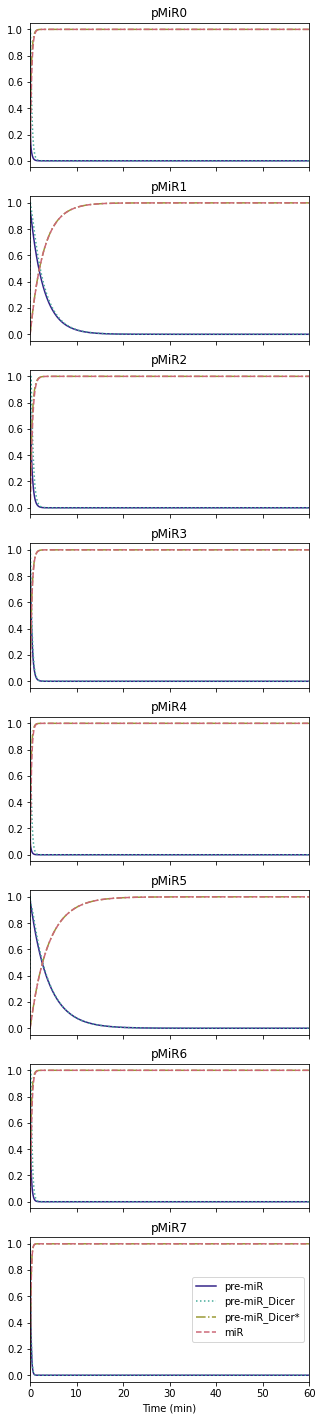

In [35]:
#plot all species on same plot for .5nM Dicer
fig, ax = plt.subplots(8, sharex = True, sharey = True, figsize = (5, 25))

for i in range(8):
    ax[i].plot(model_1500['time_min'],
               model_1500['pMiR' + str(i)] / np.max(np.array(model_1500['pMiR' + str(i)])),
               color = params.colors[0][0],
               linestyle = ['-', ':', '-.', '--'][0])
    ax[i].plot(model_1500['time_min'],
               model_1500['pMiR_dicer' + str(i)] / np.max(np.array(model_1500['pMiR_dicer' + str(i)])),
               color = params.colors[1][0],
               linestyle = ['-', ':', '-.', '--'][1])
    ax[i].plot(model_1500['time_min'],
               model_1500['pMiR_dicer_star' + str(i)] / np.max(np.array(model_1500['pMiR_dicer_star' + str(i)])),
               color = params.colors[2][0],
               linestyle = ['-', ':', '-.', '--'][2])
    ax[i].plot(model_1500['time_min'],
               model_1500['miR' + str(i)] / np.max(np.array(model_1500['miR' + str(i)])),
               color = params.colors[3][0],
               linestyle = ['-', ':', '-.', '--'][3])
    ax[i].set_title('pMiR' + str(i))
    ax[i].set_xlim(0, 60)
    
    leg = []
    for j in range(4):
        leg.append(mlines.Line2D([], [], linestyle = ['-', ':', '-.', '--'][j],
                                 color = params.colors[j][0],
                                 label = ['pre-miR', 'pre-miR_Dicer', 'pre-miR_Dicer*', 'miR'][j]))
        
    plt.legend(handles = leg)
    
ax[-1].set_xlabel('Time (min)')

plt.savefig(destdir_figs + 'time_15nM-Dicer.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

## Investigate varying pre-miRNA concentrations (evenly) on effect on mature miRNA fold change

In [36]:
#pre-miRNA concentration variations
pvars = np.linspace(0, 1, 5)
pvars = np.append(pvars, np.linspace(1.5, 5, 8))
p_variations = [str(int(i*100)) for i in list(pvars)]

In [37]:
exec(model)

In [38]:
names2 = []
for ii in tqdm(range(len(dvars))):
    for ik in range(len(pvars)):
        name = 'model_d' + variations[ii] + '_' + p_variations[ik]
            
        init = [i * pvars[ik] for i in inits1] + [dvars[ii]]
            
        res = solve_ivp(runModel, (0, 3000), init, \
                        args = (ka, kb, kc, kd), method = 'LSODA')
    
        mirna_length = int((len(res.y)-1)/4)
        index = []
    
        for j in range(mirna_length):
            index = index + ['pMiR' + str(j), 'pMiR_dicer' + str(j), \
                                 'pMiR_dicer_star' + str(j), 'miR' + str(j)]
    
        index = index + ['dicer']
    
        df = pd.DataFrame(res.y, index = index)
        df = df.transpose()
        df.insert(loc = 0, column = 'time_min', value = res.t)
    
        names2.append(name)
    
        df.to_csv(destdir_csvs + name + '.csv', index = False)

df1 = pd.DataFrame({'names': names2})
df1.to_csv(destdir_csvs + 'names2.csv', index = False)

100%|██████████| 19/19 [00:05<00:00,  3.28it/s]


In [39]:
exec(model_control)

In [40]:
inits_control

[1, 0, 0, 0]

In [41]:
names_control2 = []
for l in tqdm(range(len(ka))):
    for i in range(len(dvars)):
        for ik in range(len(pvars)):
            init = [i * pvars[ik] for i in inits_control] + [dvars[i]]
            #up time model run to reach steady state
            res = solve_ivp(runModel, (0, 3000), init, \
                            args = ([ka[l]], [kb[l]], [kc[l]], [kd[l]]), method = 'LSODA')
            mirna_length = int((len(res.y)-1)/4)
            index = []

            index = ['pMiR', 'pMiR_dicer', 'pMiR_dicer_star', 'miR', 'dicer']

            df = pd.DataFrame(res.y, index = index)
            df = df.transpose()
            df.insert(loc = 0, column = 'time_min', value = res.t)

            name = 'miRNA' + str(l) + '_control_' + variations[i] + p_variations[ik]
            names_control2.append(name)

            df.to_csv(destdir_csvs + name + '.csv', index = False)

100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


In [42]:
for name in names2:
    exec(name  + ' = pd.read_csv("' + destdir_csvs + name + '.csv", header = [0])')

In [43]:
for name in names_control2:
    exec(name  + ' = pd.read_csv("' + destdir_csvs + name + '.csv", header = [0])')

In [62]:
fcs2 = np.zeros((8, len(pvars), len(dvars)))
tot_fc = np.zeros((len(pvars), len(dvars)))
ends2 = np.zeros((8, len(pvars), len(dvars)))
tot_ends = np.zeros((len(pvars), len(dvars)))
       
for i in range(len(pvars)):
    for j in range(len(dvars)):
        exec('miR = model_d' + variations[j] + '_' + p_variations[i])
        
        ends[0, i, j] = miR['miR0'].iloc[-1]
        ends[1, i, j] = miR['miR1'].iloc[-1]
        ends[2, i, j] = miR['miR2'].iloc[-1]
        ends[3, i, j] = miR['miR3'].iloc[-1]
        ends[4, i, j] = miR['miR4'].iloc[-1]
        ends[5, i, j] = miR['miR5'].iloc[-1]
        ends[6, i, j] = miR['miR6'].iloc[-1]
        ends[7, i, j] = miR['miR7'].iloc[-1]
        
        fcs2[0, i, j] = miR['miR0'].iloc[-1] / model_d1500_500['miR0'].iloc[-1]
        fcs2[1, i, j] = miR['miR1'].iloc[-1] / model_d1500_500['miR1'].iloc[-1]
        fcs2[2, i, j] = miR['miR2'].iloc[-1] / model_d1500_500['miR2'].iloc[-1]
        fcs2[3, i, j] = miR['miR3'].iloc[-1] / model_d1500_500['miR3'].iloc[-1]
        fcs2[4, i, j] = miR['miR4'].iloc[-1] / model_d1500_500['miR4'].iloc[-1]
        fcs2[5, i, j] = miR['miR5'].iloc[-1] / model_d1500_500['miR5'].iloc[-1]
        fcs2[6, i, j] = miR['miR6'].iloc[-1] / model_d1500_500['miR6'].iloc[-1]
        fcs2[7, i, j] = miR['miR7'].iloc[-1] / model_d1500_500['miR7'].iloc[-1]
        
        tot_fc[i,j] = (miR['miR0'].iloc[-1]  + \
                 miR['miR1'].iloc[-1]  + \
                 miR['miR2'].iloc[-1]  + \
                 miR['miR3'].iloc[-1]  + \
                 miR['miR4'].iloc[-1]  + \
                 miR['miR5'].iloc[-1]  + \
                 miR['miR6'].iloc[-1]  + \
                 miR['miR7'].iloc[-1] ) / \
                (model_d1500_500['miR0'].iloc[-1] + \
                 model_d1500_500['miR1'].iloc[-1] + \
                 model_d1500_500['miR2'].iloc[-1] + \
                 model_d1500_500['miR3'].iloc[-1] + \
                 model_d1500_500['miR4'].iloc[-1] + \
                 model_d1500_500['miR5'].iloc[-1] + \
                 model_d1500_500['miR6'].iloc[-1] + \
                 model_d1500_500['miR7'].iloc[-1] )
        
        tot_ends[i,j] = (miR['miR0'].iloc[-1]  + \
                 miR['miR1'].iloc[-1]  + \
                 miR['miR2'].iloc[-1]  + \
                 miR['miR3'].iloc[-1]  + \
                 miR['miR4'].iloc[-1]  + \
                 miR['miR5'].iloc[-1]  + \
                 miR['miR6'].iloc[-1]  + \
                 miR['miR7'].iloc[-1] )

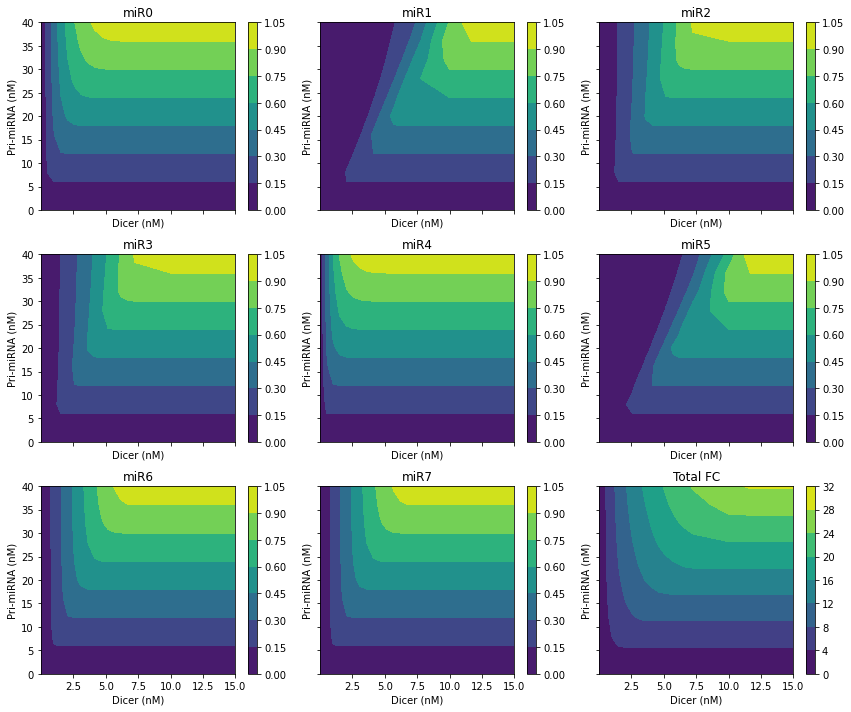

In [64]:
fig, ax  = plt.subplots(3,3, sharex = True, sharey = True, figsize = (12,10))

coords = createCoordinates(3,3)

x = dvars
y = [8*i for i in pvars]

for i in range(9):
    if i < 8:
        cs = ax[coords[i]].contourf(x, y, fcs2[i])
        ax[coords[i]].set_title('miR' + str(i))
        fig.colorbar(cs)
    else:
        cs = ax[coords[i]].contourf(x, y, tot_ends)
        ax[coords[i]].set_title('Total FC')
        fig.colorbar(cs)
    
    ax[coords[i]].set_xlabel('Dicer (nM)')
    ax[coords[i]].set_ylabel('Pri-miRNA (nM)')


fig.tight_layout()

plt.savefig(destdir_figs + 'premir-vars.svg', dpi = 600, bbox_inches = 'tight')
plt.show()